# Empirical PDF functions

How to calculate the PDF, CDF and SF from empirical data.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

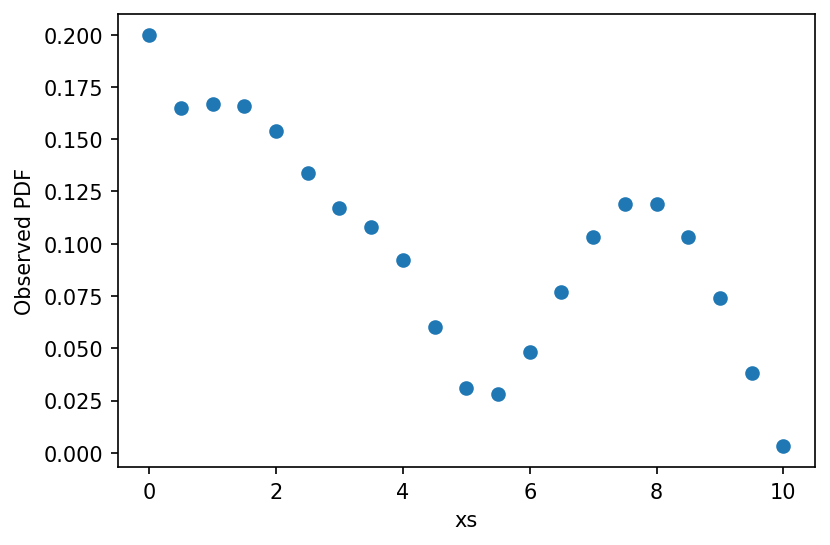

In [15]:
xs = [0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 
      5.0, 5.5, 6.0, 6.5, 7.0, 7.5, 8.0, 8.5, 9.0, 9.5, 10.0]
ys = [0.2, 0.165, 0.167, 0.166, 0.154, 0.134, 0.117, 
      0.108, 0.092, 0.06, 0.031, 0.028, 0.048, 0.077, 
      0.103, 0.119, 0.119, 0.103, 0.074, 0.038, 0.003]

plt.rcParams['figure.dpi'] = 150
plt.scatter(xs, ys)
plt.xlabel("xs")
plt.ylabel("Observed PDF");

# The data is probably from a continuous distribution that has been binned
# Interpolate between the datapoints to fill in the blanks

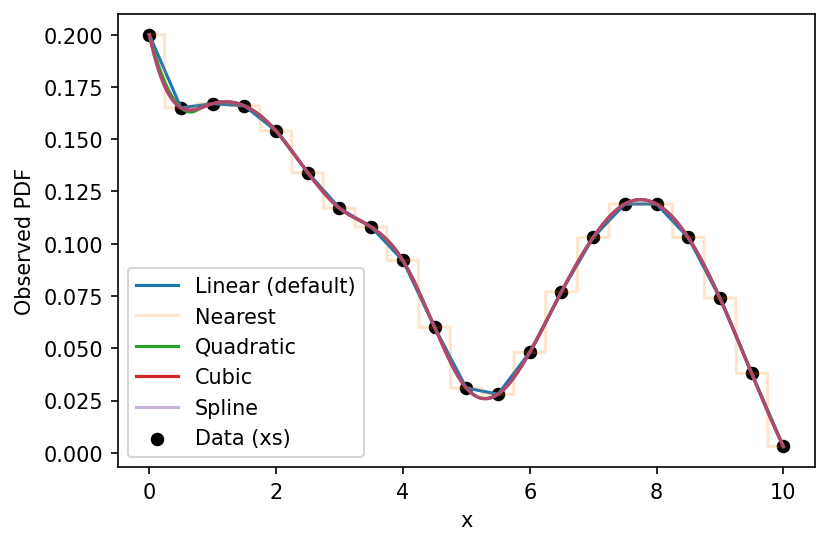

In [16]:
# Create an x array that contains datapoints that span from the beginning to the and of xs
x = np.linspace(min(xs), max(xs), 1000)

# Different methods of interpolations

# Linear Interpolation - Roughly accurate with lots of data, not good when data changes a lot (curves/gradients)

# interp1d returns a function which can be called with an array of different x-values (x),
# to get new y-values evaluated at the positions of the array x, using/interpolating the (xs, ys) data
y1 = interp1d(xs, ys)(x)

# Nearest Neighbor - Maybe okay with discrete data, but continuous data that is smoothly changing -> inappropriate
y2 = interp1d(xs, ys, kind="nearest")(x)

# Quadratic Fit
y3 = interp1d(xs, ys, kind="quadratic")(x)

# Cubic Fit
y4 = interp1d(xs, ys, kind="cubic")(x)

# Higher order fits takes longer to compute, if your data requires that, you might as well do splining
# Also, splines are better than higher order fits
# Make sure thta you have enough data if you think this is required
# Interpolation methods can lead to bias, be careful
# Import spline evalutaion and spline representation
from scipy.interpolate import splev, splrep
y5 = splev(x, splrep(xs, ys)) #splrep turns initial data (xs, ys) into a spline, splev evaluates it at x points

plt.scatter(xs, ys, s=30, label="Data (xs)", c="k")
plt.plot(x, y1, label="Linear (default)") # Straight lines between points, no curving
plt.plot(x, y2, label="Nearest", alpha=0.2) # No... just no
plt.plot(x, y3, label="Quadratic") # Now curves between the datapoints
plt.plot(x, y4, label="Cubic") # Data is smooth enough that there is no difference between the quadratic
plt.plot(x, y5, label="Spline", alpha=0.5) # Exactly on top of the cubic fit
plt.xlabel("x")
plt.ylabel("Observed PDF");
plt.legend();
# Using interp1d we can find the probability for any x value (assuming it's normalised, otherwise it's a pseudo-probability..)

How can we calculate the CDF and the probability we would find a value between two bounds? Using `scipy.integrate`. Scipy to the rescue once again!

We have many options:
- h is the steps between the x values (difference between the samples)
- Trapezoidal Rule - takes the datapoints and make a trapezium out of them and gets the area
  - Think of it as a Linear Interpolation
  - 10x the step count -> 10x the accuracy
* `scipy.integrate.trapz` for low accuracy but high speed. Accuracy scales as `O(h)`

- Simpsons Rule - Quadratic Interpolation
  - 10x the step count -> 100x the accuracy
  - Usually the best choice
* `scipy.integrate.simps` for medium accuracy and pretty high speed. Accuracy scales as `O(h^2)`

- Uses any function as it sees fit, until it is satisfied that it converged at the right answer
  - Will iterate until it gets the answer
  - For a perfect answer
* `scipy.integrate.quad` for high accuracy and low sped. Arbitrary accuracy.

There are a few more functions, look them up if you're curious.

In [19]:
from scipy.integrate import simps

def get_prob(xs, ys, a, b): # a, b -> lower and upper bound (integral from a to b)
    x_vals = np.linspace(a, b, 1000) # Can make the step count a user input
    y_vals = interp1d(xs, ys, kind="quadratic")(x_vals) # General Solution
    return simps(y_vals, x=x_vals) # double quadratic sort of defeats the purpose

def get_cdf(xs, ys, v):
    # xs.min() would assume that it is a numpy array, min(xs) assumes it is a list
    return get_prob(xs, ys, min(xs), v) # big brain, just get the probability from the min to the desired value (v)

def get_sf(xs, ys, v): # Survival Function
    return 1 - get_cdf(xs, ys, v) # SF = 1 - CDF
    # or return get_prob(xs, ys, v, max(xs))

In [20]:
# Test for bugs
print(get_prob(xs, ys, 0, 10))

# A value greater than 1 because the data is not normalized....

1.0012951939288757


In [25]:
from scipy.integrate import simps

def get_prob(xs, ys, a, b, resolution=1000): # a, b -> lower and upper bound (integral from a to b)
    # Rather than assume the data is normalised properly...
    x_norm = np.linspace(min(xs), max(xs), resolution)
    y_norm = interp1d(xs, ys, kind="quadratic")(x_norm) 
    # Figuring out the total area under the curve
    normalisation = simps(y_norm, x=x_norm)
    x_vals = np.linspace(a, b, resolution) # Can make the step count a user input
    y_vals = interp1d(xs, ys, kind="quadratic")(x_vals) # General Solution
    # Divide the final result by normalisation to ensure the area is equal to one
    return simps(y_vals, x=x_vals) / normalisation

def get_cdf(xs, ys, v):
    # xs.min() would assume that it is a numpy array, min(xs) assumes it is a list
    return get_prob(xs, ys, min(xs), v) # big brain, just get the probability from the min to the desired value (v)

def get_sf(xs, ys, v): # Survival Function
    return 1 - get_cdf(xs, ys, v) # SF = 1 - CDF
    # or return get_prob(xs, ys, v, max(xs))

In [26]:
# Test again
print(get_prob(xs, ys, 0, 10))
# Note: using a resolution of 100 makes the data no longer normalised....

1.0


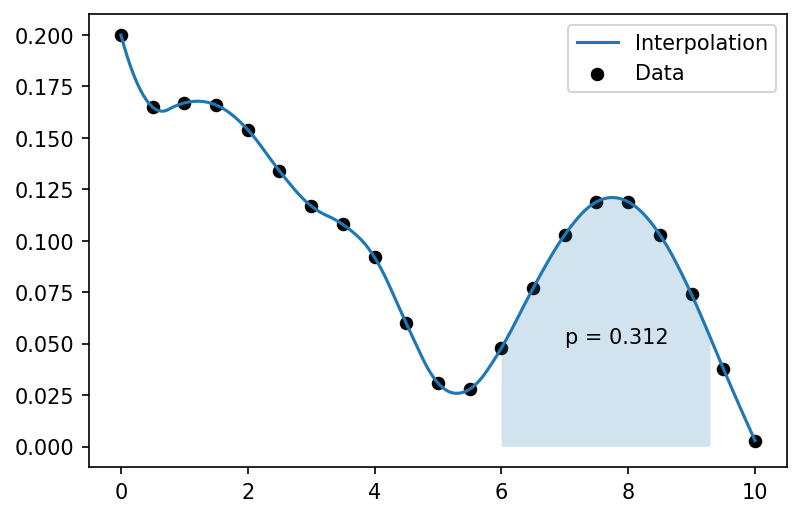

In [30]:
v1, v2 = 6, 9.3
area = get_prob(xs, ys, v1, v2)

plt.scatter(xs, ys, s=30, label="Data", color="k")
plt.plot(x, y3, linestyle="-", label="Interpolation")
plt.fill_between(x, 0, y3, where=(x>=v1)&(x<=v2), alpha=0.2) # fill from 0 to curve, from v1 to v2
plt.annotate(f"p = {area:.3f}", (7, 0.05)) # text location starts at (7, 0.05)
plt.legend();

C:\ProgramData\Anaconda3\lib\site-packages\scipy\integrate\_quadrature.py:397: RuntimeWarning: invalid value encountered in true_divide
  h0divh1 = h0 / h1
C:\ProgramData\Anaconda3\lib\site-packages\scipy\integrate\_quadrature.py:399: RuntimeWarning: invalid value encountered in true_divide
  y[slice1]*hsum*hsum/hprod +


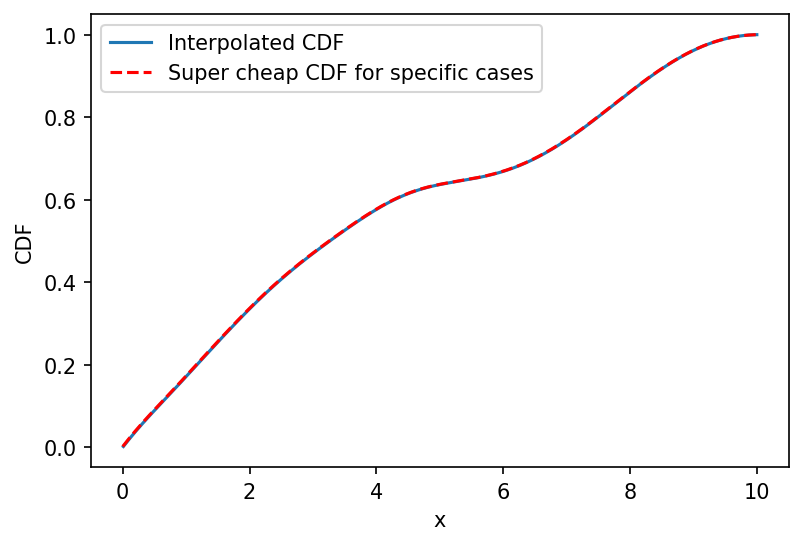

In [36]:
# Get CDF plot, but quick and dirty

x_new = np.linspace(min(xs), max(xs), 1000)

# Computationally Expensive - quadratic interp1d function into the simpsons rule for area for every single datapoint
cdf_new = [get_cdf(xs, ys, i) for i in x_new]

# Very Quick and Dirty
# Take the cummulative sum of the quadratic interpolation and normalise it (Remember that CDF goes to 1)
# Perfect in most cases. The uncertainty from data samples far outweighs the uncertainty from the method used for integration
cheap_cdf = y3.cumsum() / y3.sum() # Effectively the rectangle rule, good for smooth data :)

plt.plot(x_new, cdf_new, label="Interpolated CDF")
plt.plot(x, cheap_cdf, label="Super cheap CDF for specific cases", c='r', ls='--')
plt.legend()
plt.ylabel("CDF")
plt.xlabel("x");

# Moral: only use more complex methods as needed rather than jumping straight into it for no reason